In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

## Data Loading

In [2]:
df = pd.read_parquet("../dataset/curated/marts_ml_train_sel_all.parquet")
df.head()

,price,kamar_tidur,kamar_mandi,kamar_pembantu,kamar_mandi_pembantu,dapur,luas_tanah,luas_bangunan,jumlah_lantai,garasi,...,facility_aula,facility_canopy,facility_shed,facility_gas,facility_heating,facility_musholla,facility_floorboards,facility_mezzanine,facility_lemari_pakaian,facility_lemari_sepatu
0,4200.0,3,4,1,1,1,216.0,250.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100.0,3,1,0,0,1,90.0,70.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000.0,4,3,0,0,1,1506.0,200.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,450.0,3,2,0,0,1,42.0,58.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1500.0,4,2,0,0,1,285.0,156.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot Pearson Correlations: Specs

<Axes: >

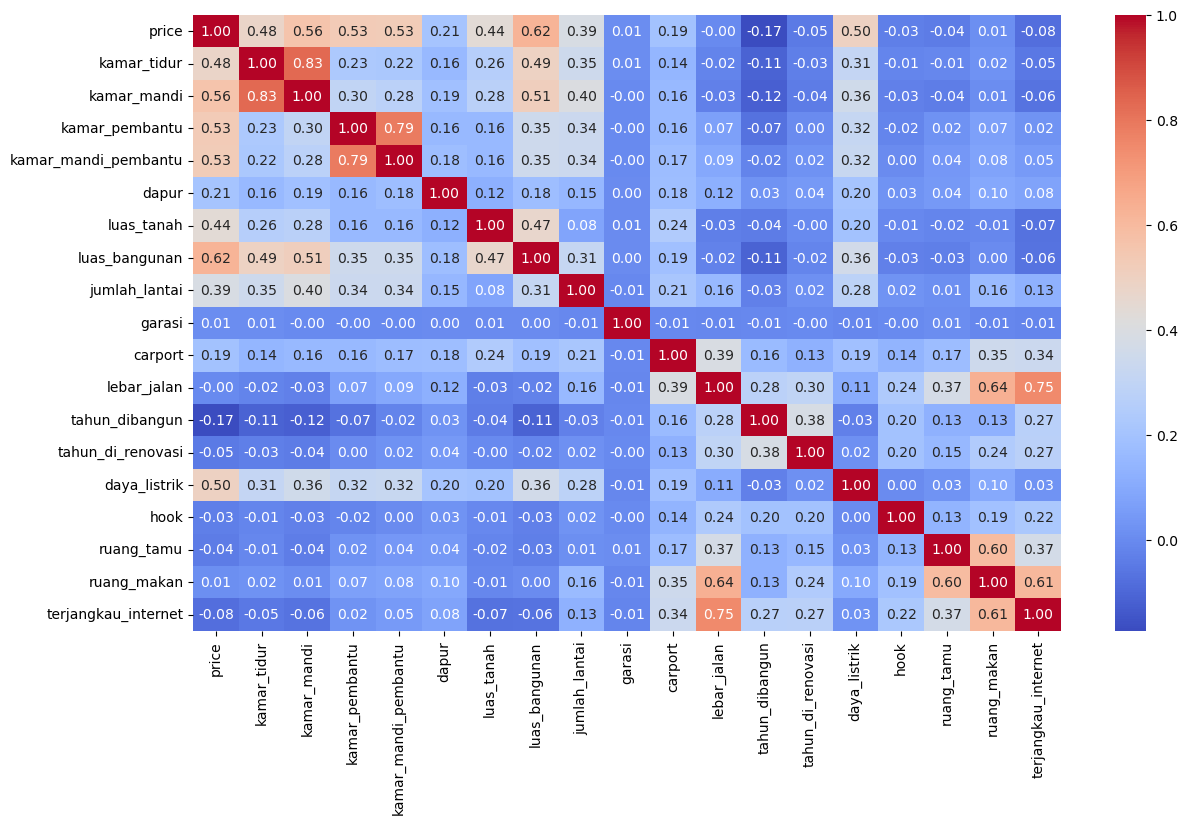

In [3]:
numeric_cols = df.select_dtypes('number').columns
cols = [col for col in df.columns if not col.startswith('facility_') and not col.startswith('tag_') and not col.startswith('floor_mat_') and not col.startswith('house_mat_')]
cols = [col for col in cols if col in numeric_cols]

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

### Plot Pearson Correlations: Floor Material

<Axes: >

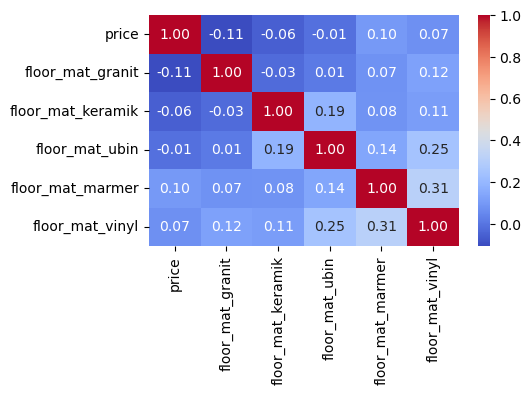

In [4]:
cols = ["price"] + [col for col in df.columns if col.startswith("floor_mat_")]

fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

### Plot Peason Correlations: House Material

<Axes: >

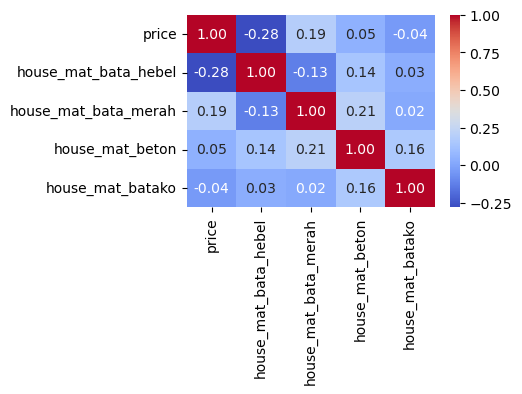

In [5]:
cols = ["price"] + [col for col in df.columns if col.startswith("house_mat_")]

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

### Plot Pearson Correlations: Tags

<Axes: >

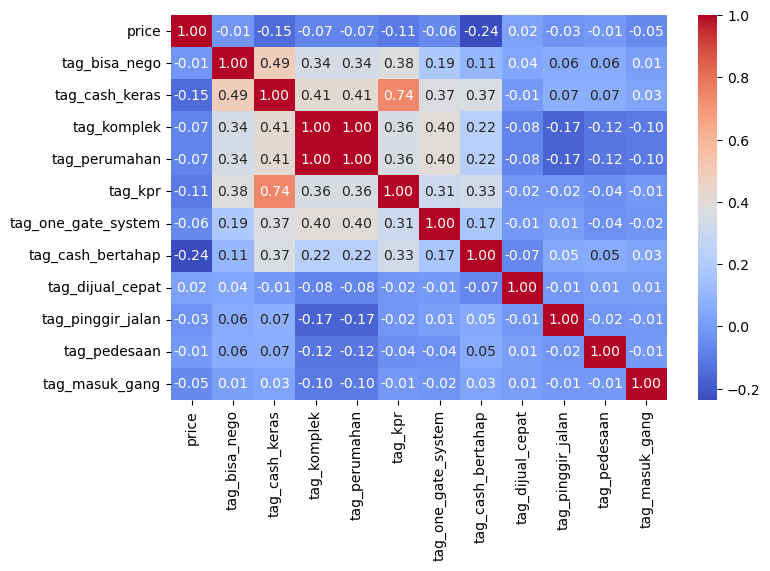

In [6]:
cols = ["price"] + [col for col in df.columns if col.startswith("tag_")]

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

### Plot Pearson Correlations: Facility

<Axes: >

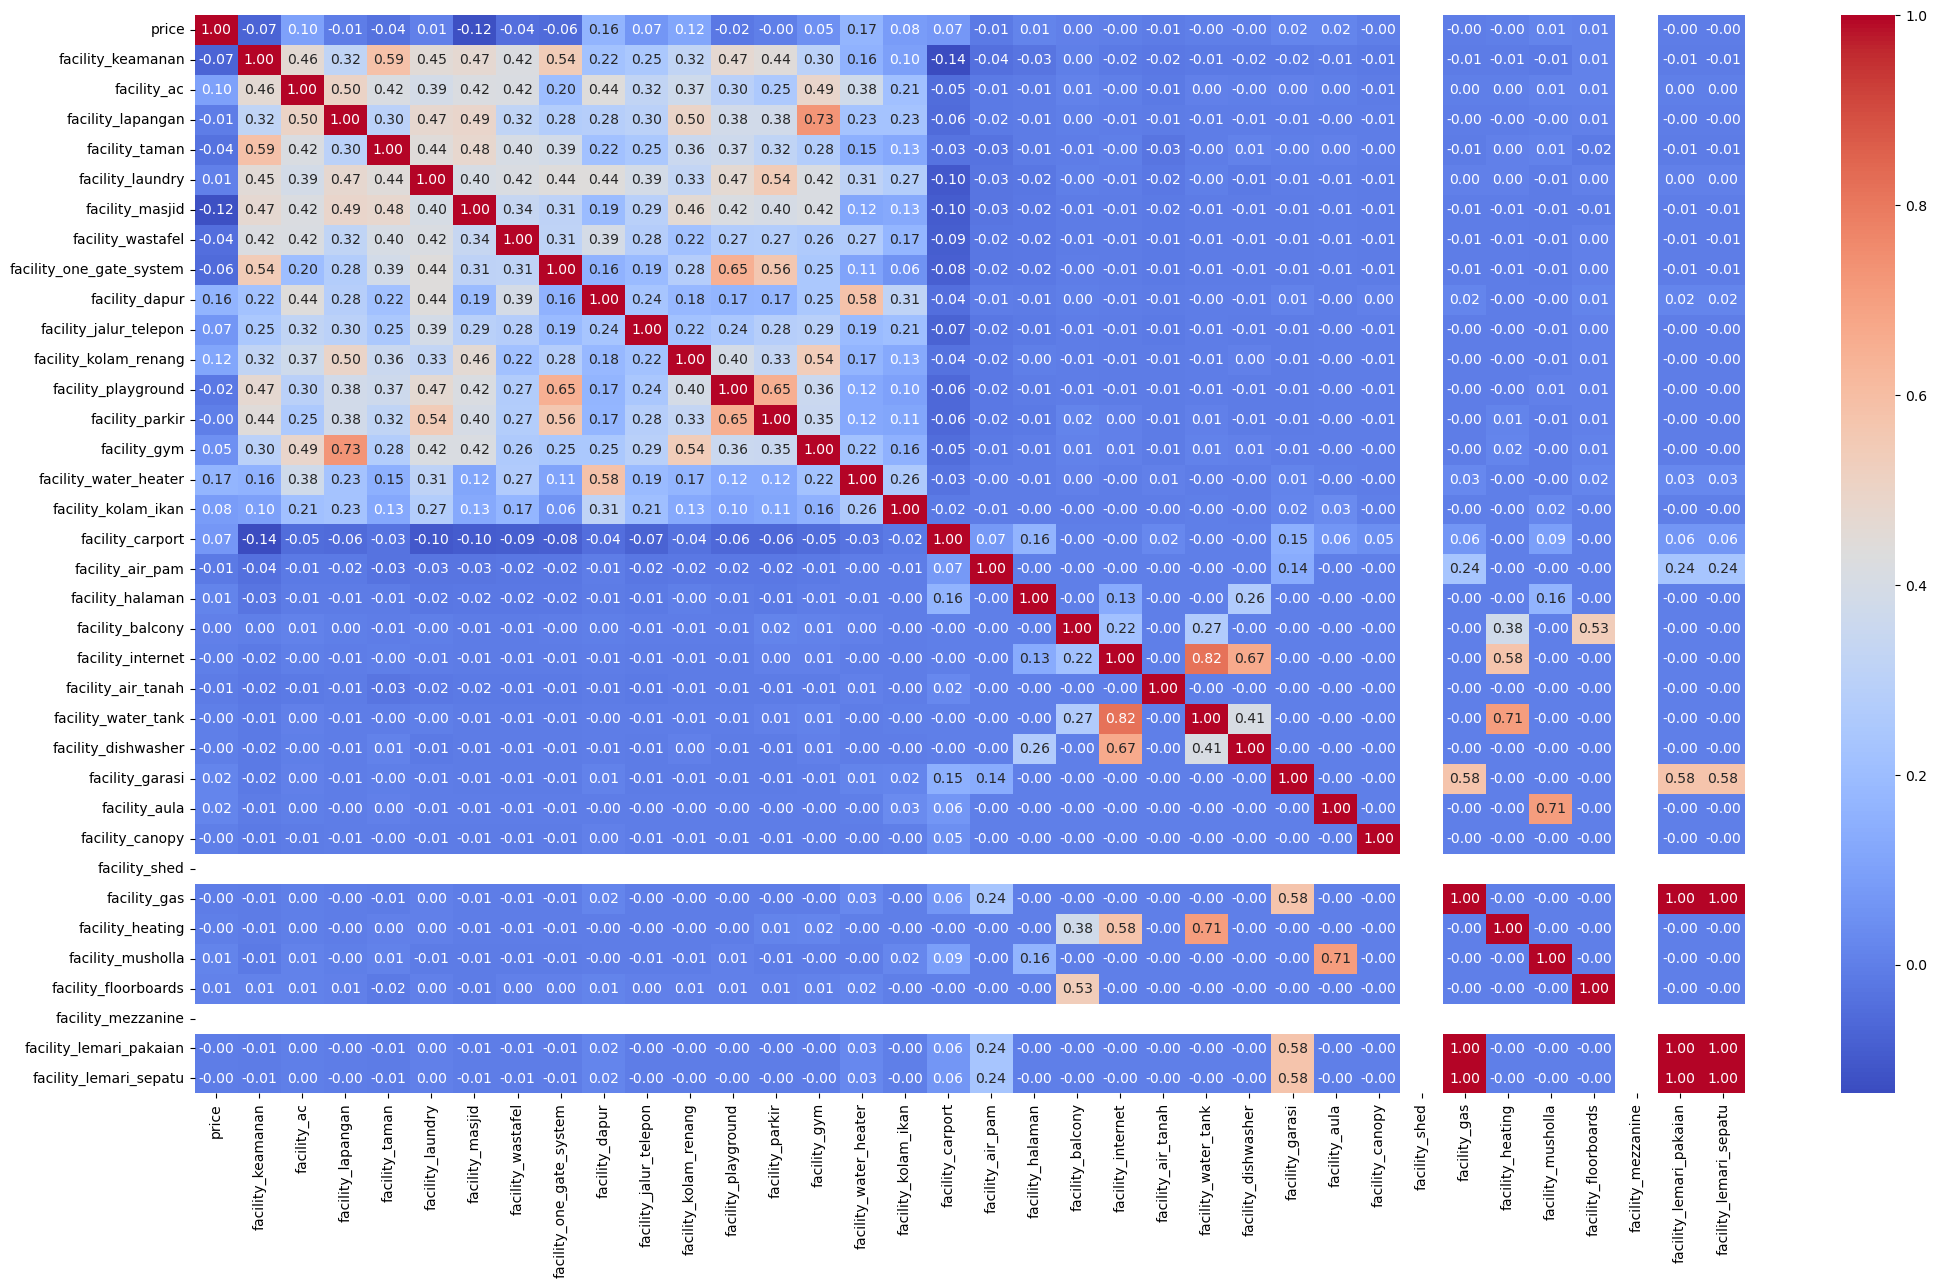

In [7]:
cols = ["price"] + [col for col in df.columns if col.startswith("facility_")]

fig, ax = plt.subplots(figsize=(25, 14))
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

## Correlation and Statistical Significance

In [8]:
def formatter_pvalue(x):
    return "color: red" if x < 0.05 else None

def should_use_point_biser_corr(column):
    return "tag_" in column or "facility_" in column or "_mat_" in column

In [9]:
corrs = []
for column in df.select_dtypes('number').columns:
    # if this is price, skip
    if column == "price":
        continue
  
    # calculate correlation
    if should_use_point_biser_corr(column):
        method = "pointbiser"
        corr = stats.pointbiserialr(df[column], df["price"])
    else:
        method = "pearson"
        corr = stats.pearsonr(df[column], df["price"])

    # append to corrs
    corrs.append({
        "variable": column,
        "method": method,
        "correlation": corr[0],
        "p_value": corr[1]
    })

# create dataframe
df_corr = pd.DataFrame(corrs)
df_corr["correlation_abs"] = df_corr["correlation"].abs()
df_corr.head()

/home/fahmi/.mambaforge/envs/rumah/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5546: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,variable,method,correlation,p_value,correlation_abs
0,kamar_tidur,pearson,0.480799,0.000000e+00,0.480799
1,kamar_mandi,pearson,0.562766,0.000000e+00,0.562766
2,kamar_pembantu,pearson,0.528685,0.000000e+00,0.528685
3,kamar_mandi_pembantu,pearson,0.527060,0.000000e+00,0.527060
4,dapur,pearson,0.207179,4.900309e-176,0.207179


In [10]:
df_corr.sort_values("correlation_abs", ascending=False).style \
    .background_gradient(subset=["correlation_abs"]) \
    .map(formatter_pvalue, subset=["p_value"])

,variable,method,correlation,p_value,correlation_abs
6,luas_bangunan,pearson,0.623182,0.000000,0.623182
1,kamar_mandi,pearson,0.562766,0.000000,0.562766
2,kamar_pembantu,pearson,0.528685,0.000000,0.528685
3,kamar_mandi_pembantu,pearson,0.527060,0.000000,0.527060
13,daya_listrik,pearson,0.498883,0.000000,0.498883
0,kamar_tidur,pearson,0.480799,0.000000,0.480799
5,luas_tanah,pearson,0.440159,0.000000,0.440159
7,jumlah_lantai,pearson,0.389876,0.000000,0.389876
18,house_mat_bata_hebel,pointbiser,-0.280369,0.000000,0.280369
33,tag_cash_bertahap,pointbiser,-0.236790,0.000000,0.236790


## Feature Cardinality

In [11]:
def cardinality_measure(series):
    value_counts = series.value_counts(normalize=True)
    return np.sqrt(np.sum(np.square(value_counts.values)))

In [12]:
df_cat = pd.DataFrame({
  "variable": df.columns,
  "max_category": df.apply(lambda x: x.value_counts(normalize=True).max(), axis=0),
  "cardinality_measure": df.apply(cardinality_measure, axis=0)
}).reset_index(drop=True)

print("Total selected columns:", df_cat.shape[0])
df_cat.sort_values(by="max_category", ascending=True).style.background_gradient()

Total selected columns: 82


,variable,max_category,cardinality_measure
0,price,0.024449,0.087190
7,luas_bangunan,0.083598,0.149521
6,luas_tanah,0.107938,0.176118
2,kamar_mandi,0.400066,0.542005
1,kamar_tidur,0.404671,0.540537
14,daya_listrik,0.462449,0.572383
11,lebar_jalan,0.466506,0.608720
51,facility_laundry,0.476812,0.632932
47,facility_keamanan,0.485035,0.615685
10,carport,0.494134,0.620011


## Select by R score and Cardinality

In [13]:
candidate_corr = df_corr[df_corr["correlation_abs"] > 0.2].iloc[:, 0].tolist()
canidate_card = df_cat[df_cat["max_category"] < 0.6].iloc[:, 0].tolist()

In [14]:
set(candidate_corr + canidate_card) - set(["price"])

{'carport',
 'dapur',
 'daya_listrik',
 'facility_ac',
 'facility_keamanan',
 'facility_laundry',
 'facility_masjid',
 'house_mat_bata_hebel',
 'jumlah_lantai',
 'kamar_mandi',
 'kamar_mandi_pembantu',
 'kamar_pembantu',
 'kamar_tidur',
 'lebar_jalan',
 'luas_bangunan',
 'luas_tanah',
 'ruang_makan',
 'tag_cash_bertahap',
 'tag_komplek',
 'tag_kpr',
 'tag_perumahan',
 'tahun_dibangun'}